<a href="https://colab.research.google.com/github/dirknbr/bayesnet_attribution/blob/main/attribution_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install pyagrum

# Attribution using Bayesian nets

We have 3 channels that drive a conversion

(C1, C2, C3) all drive Conv

C1 also drives (C2, C3)

We can estimate most conditional probabilites like P(conv|C1, C2, C3) etc.

We populate the BN and then get the channel effect as $P(conv|C1) - P(conv|\neg C1)$

In [48]:
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [49]:
# create the net
bn = gum.BayesNet.fastPrototype("c1->c2->conv<-c3; c1->conv; c1->c3")
bn

(pyAgrum.BayesNet<double>@0x55fea6f05800) BN{nodes: 4, arcs: 5, domainSize: 16, dim: 26}

In [50]:
# we initialise with 1+4+8=13 conditional probabilities
bn.cpt('c1')[:] = [.9, .1]
bn.cpt('c2')[{'c1': 1}] = [.8, .2] # P(c2|c1)
bn.cpt('c2')[{'c1': 0}] = [.9, .1] # P(c2|c1=0)
bn.cpt('c3')[{'c1': 1}] = [.7, .3] # P(c3|c1)
bn.cpt('c3')[{'c1': 0}] = [.8, .2] # P(c3|c1=0)
bn.cpt('conv')[{'c1': 0, 'c2': 0, 'c3': 0}] = [.995, .005] # P(conv|none)
bn.cpt('conv')[{'c1': 1, 'c2': 0, 'c3': 0}] = [.99, .01] # P(conv|c1 only)
bn.cpt('conv')[{'c1': 1, 'c2': 1, 'c3': 0}] = [.98, .02] # P(conv|c1+c2)
bn.cpt('conv')[{'c1': 0, 'c2': 1, 'c3': 1}] = [.965, .035] # P(conv|c2+c3)
bn.cpt('conv')[{'c1': 1, 'c2': 0, 'c3': 1}] = [.96, .04] # P(conv|c1+c3)
bn.cpt('conv')[{'c1': 0, 'c2': 1, 'c3': 0}] = [.98, .02] # P(conv|c2 only)
bn.cpt('conv')[{'c1': 0, 'c2': 0, 'c3': 1}] = [.97, .03] # P(conv|c3 only)
bn.cpt('conv')[{'c1': 1, 'c2': 1, 'c3': 1}] = [.95, .05] # P(conv|c1+c2+c3)


In [51]:
# https://pyagrum.readthedocs.io/en/0.22.5/BNInference.html?highlight=LazyPropagation#pyAgrum.LazyPropagation
ie = gum.LazyPropagation(bn)

In [52]:
ie.makeInference()

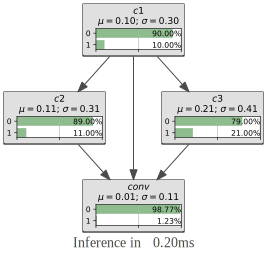

In [53]:
# P(conv)
gnb.showInference(bn,evs={})

In [59]:
# attribution effects P(conv|do(c1))
# the value of c1 is P(conv|c1) - P(conv|c1=0)

ie.setEvidence({'c1': 0})
ie.makeInference()
p0 = ie.posterior("conv")

ie.setEvidence({'c1': 1})
ie.makeInference()
p1 = ie.posterior("conv")

p0, p1, p1 - p0

((pyAgrum.Potential<double>@0x55fea7093bc0) 
   conv             |
 0        |1        |
 ---------|---------|
  0.9887  | 0.0113  |, (pyAgrum.Potential<double>@0x55fea7092c80) 
   conv             |
 0        |1        |
 ---------|---------|
  0.9790  | 0.0210  |, (pyAgrum.Potential<double>@0x55fea7093940) 
   conv             |
 0        |1        |
 ---------|---------|
  -0.0097 | 0.0097  |)

In [61]:
ie.setEvidence({'c2': 0})
ie.makeInference()
p0 = ie.posterior("conv")

ie.setEvidence({'c2': 1})
ie.makeInference()
p1 = ie.posterior("conv")

p0, p1, p1 - p0

((pyAgrum.Potential<double>@0x55fea7074120) 
   conv             |
 0        |1        |
 ---------|---------|
  0.9892  | 0.0108  |, (pyAgrum.Potential<double>@0x55fea7c8fb40) 
   conv             |
 0        |1        |
 ---------|---------|
  0.9759  | 0.0241  |, (pyAgrum.Potential<double>@0x55fea7c8fec0) 
   conv             |
 0        |1        |
 ---------|---------|
  -0.0133 | 0.0133  |)

In [62]:
ie.setEvidence({'c3': 0})
ie.makeInference()
p0 = ie.posterior("conv")

ie.setEvidence({'c3': 1})
ie.makeInference()
p1 = ie.posterior("conv")

p0, p1, p1 - p0

((pyAgrum.Potential<double>@0x55fea7c8ef80) 
   conv             |
 0        |1        |
 ---------|---------|
  0.9930  | 0.0070  |, (pyAgrum.Potential<double>@0x55fea7c8f820) 
   conv             |
 0        |1        |
 ---------|---------|
  0.9679  | 0.0321  |, (pyAgrum.Potential<double>@0x55fea7074720) 
   conv             |
 0        |1        |
 ---------|---------|
  -0.0252 | 0.0252  |)